# using mnist dataset to test trained model LeNet-5

In [1]:
# import the necessary packages
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn
from torchinfo import summary
from torchmetrics import Accuracy
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Download the MNIST dataset
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=True)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=True)

# Dataset summary
print("Train/Validation dataset size:", len(train_val_dataset))
print("Test dataset size:", len(test_dataset))

class_names = train_val_dataset.classes
print("Class names:", class_names)

Train/Validation dataset size: 60000
Test dataset size: 10000
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [3]:
# convert the datasets into tensors
transform = transforms.ToTensor()
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=False, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="./datasets", train=False, download=False, transform=transforms.ToTensor())

# Data Normalization
# Calculate mean and std
imgs = torch.stack([img for img, _ in train_val_dataset], dim=0)
mean = imgs.view(1, -1).mean(dim=1)    # or imgs.mean()
std = imgs.view(1, -1).std(dim=1)     # or imgs.std()
print("Mean:", mean)
print("Std:", std)
# Composition of transforms
mnist_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)])

# Apply transforms to datasets
train_val_dataset = datasets.MNIST(root="./datasets/", train=True, download=False, transform=mnist_transforms)
test_dataset = datasets.MNIST(root="./datasets/", train=False, download=False, transform=mnist_transforms)

Mean: tensor([0.1307])
Std: tensor([0.3081])


In [4]:
# Split train and validation datasets
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset=train_val_dataset, lengths=[train_size, val_size])

In [5]:
# Dataset summary
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 54000
Validation dataset size: 6000
Test dataset size: 10000


In [6]:
# Create dataloaders
# check memory available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# set batch size based on available memory
BATCH_SIZE = 128 if device == "cuda" else 64

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Summary of dataloaders
print("Train dataloader size:", len(train_dataloader))
print("Validation dataloader size:", len(val_dataloader))
print("Test dataloader size:", len(test_dataloader))

Device: cpu
Train dataloader size: 844
Validation dataloader size: 94
Test dataloader size: 157


In [7]:
# LeNet-5 architecture implementation
class LeNet5_V1(nn.Module):
    def __init__(self):
        super().__init__()
        # Feature extractor
        self.feature = nn.Sequential(
            # Convolutional layers
            # First conv layer
            # input: 1 x 28 x 28 --> padding = 2 --> 1 x 32 x 32 --> 6 x 28 x 28
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
            # activation function
            nn.Sigmoid(),
            # pooling layer 14 x 14
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second conv layer
            # input: 6 x 14 x 14 --> 16 x 10 x 10
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            # activation function
            nn.Sigmoid(),
            # pooling layer 5 x 5
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Classifier
        self.classifier = nn.Sequential(
            # Fully connected layers
            # First fc layer
            # input: 16 x 5 x 5 = 400 --> 120
            # flatten
            nn.Flatten(),
            # fc layer
            nn.Linear(in_features=16 * 5 * 5, out_features=120),
            # activation function
            nn.Sigmoid(), # sigmoid

            # Second fc layer
            nn.Linear(in_features=120, out_features=84),

            # activation function
            nn.Sigmoid(), # sigmoid

            # Third fc layer
            nn.Linear(in_features=84, out_features=10)
        )

    def forward(self, x):
        return self.classifier(self.feature(x))

In [8]:
# Model creation
model_lenet5 = LeNet5_V1()
print(model_lenet5)

# move the model to the device
model_lenet5.to(device)

# Model summary
summary(model=model_lenet5, input_size=(1, 1, 28, 28), device=device)

LeNet5_V1(
  (feature): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)


Layer (type:depth-idx)                   Output Shape              Param #
LeNet5_V1                                [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 5, 5]             --
│    └─Conv2d: 2-1                       [1, 6, 28, 28]            156
│    └─Sigmoid: 2-2                      [1, 6, 28, 28]            --
│    └─MaxPool2d: 2-3                    [1, 6, 14, 14]            --
│    └─Conv2d: 2-4                       [1, 16, 10, 10]           2,416
│    └─Sigmoid: 2-5                      [1, 16, 10, 10]           --
│    └─MaxPool2d: 2-6                    [1, 16, 5, 5]             --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Flatten: 2-7                      [1, 400]                  --
│    └─Linear: 2-8                       [1, 120]                  48,120
│    └─Sigmoid: 2-9                      [1, 120]                  --
│    └─Linear: 2-10                      [1, 84]                   10,164
│  

In [9]:
# Loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_lenet5.parameters(), lr=1e-3)
accuracy = Accuracy(task="multiclass", num_classes=10).to(device)

In [10]:
# load model
model_lenet5.load_state_dict(torch.load(os.path.join("models", "LeNet-5_original_v2.pth")))
model_lenet5.to(device)

LeNet5_V1(
  (feature): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=400, out_features=120, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [11]:
model_lenet5.eval()

# test phase
test_loss = 0
test_acc = 0
with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(test_dataloader):
        # move data to device
        data = data.to(device)
        targets = targets.to(device)

        # forward
        scores = model_lenet5(data)
        loss = loss_fn(scores, targets)

        # calculate accuracy
        acc = accuracy(scores, targets)

        # print
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}/{len(test_dataloader)} Loss {loss:.4f} Accuracy {acc:.4f}")

        test_loss += loss
        test_acc += acc
# Average loss and accuracy
test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print(f"Test loss: {test_loss:.4f} Test accuracy: {test_acc:.4f}")

Batch 0/157 Loss 0.1042 Accuracy 0.9688
Batch 100/157 Loss 0.0862 Accuracy 0.9688
Test loss: 0.0784 Test accuracy: 0.9740


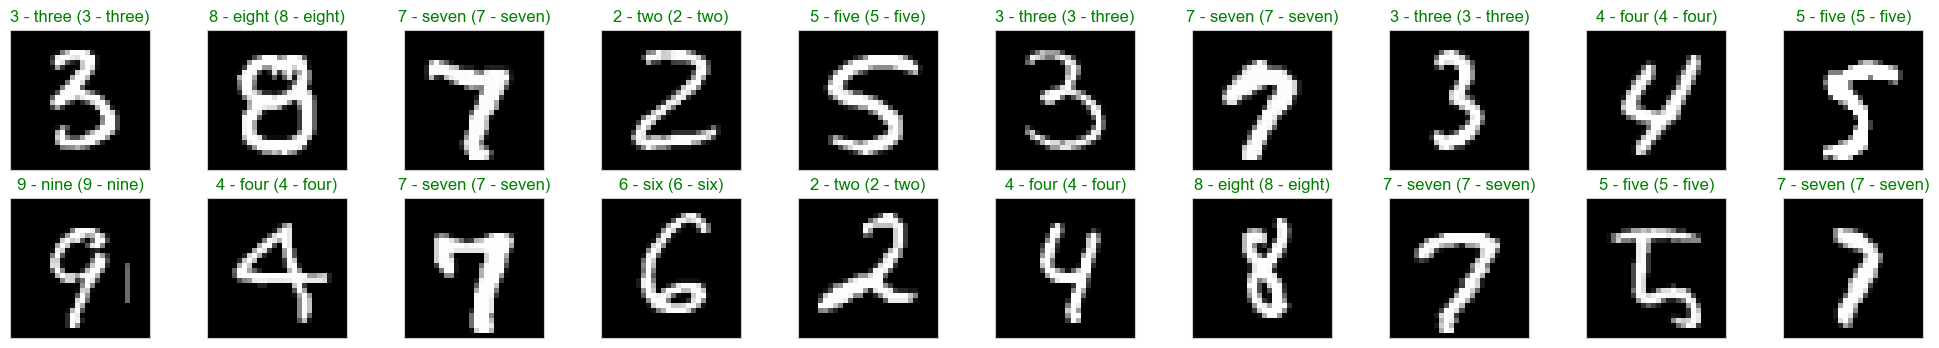

[[ 5  0  0  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0 13  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  1  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  0  6]]


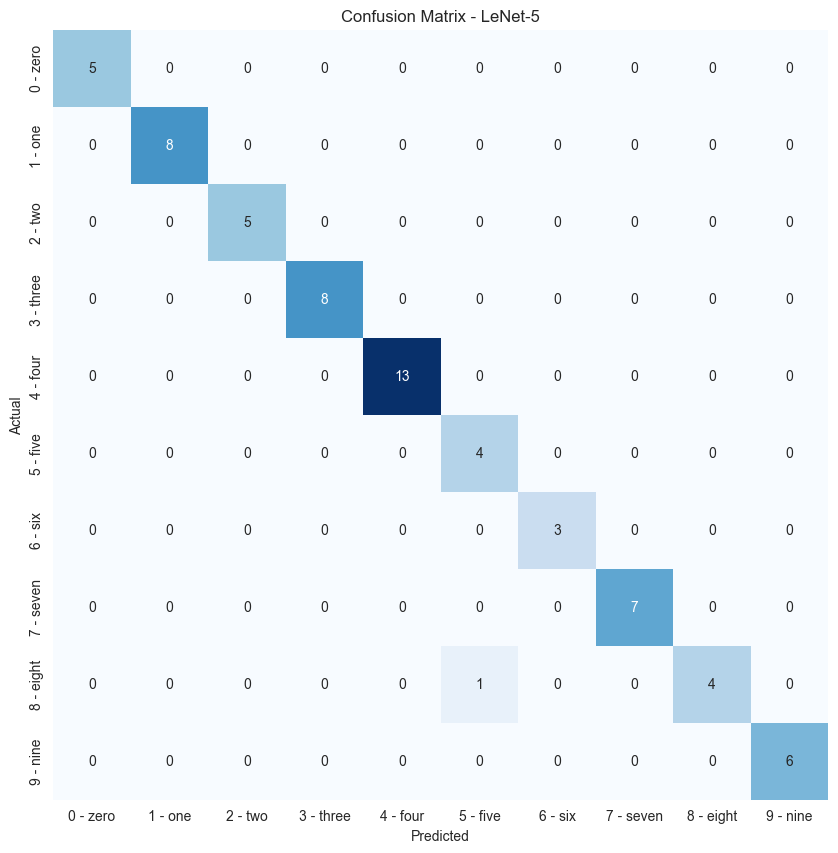

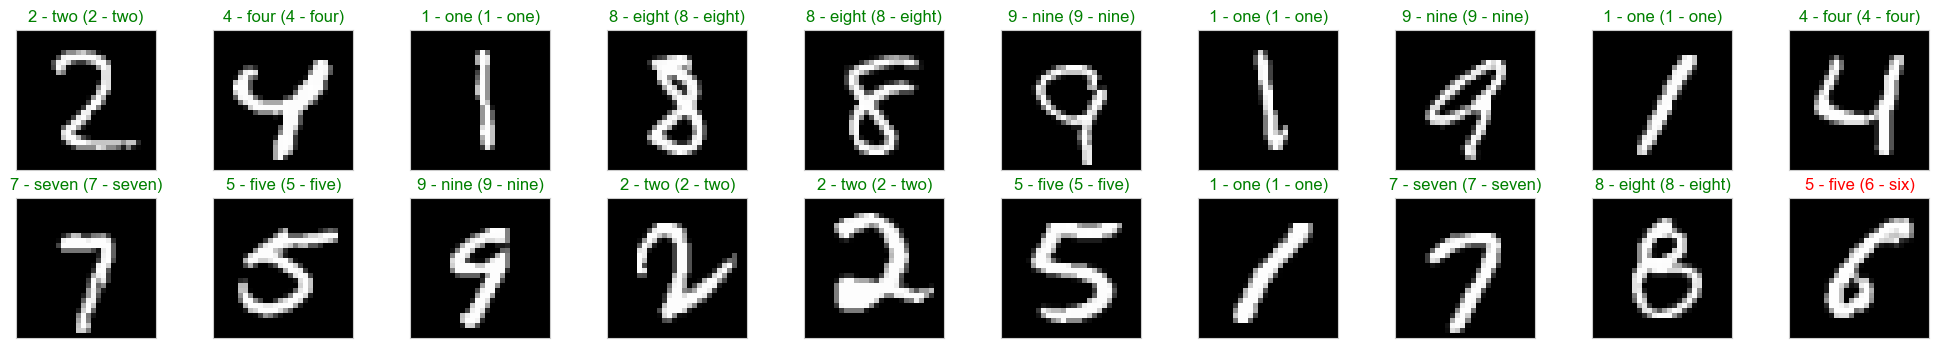

[[8 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 1 0]
 [0 0 6 1 0 0 0 0 0 0]
 [0 0 0 6 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 7 0 0 0 0]
 [0 0 0 0 0 0 7 0 0 0]
 [0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 5]]


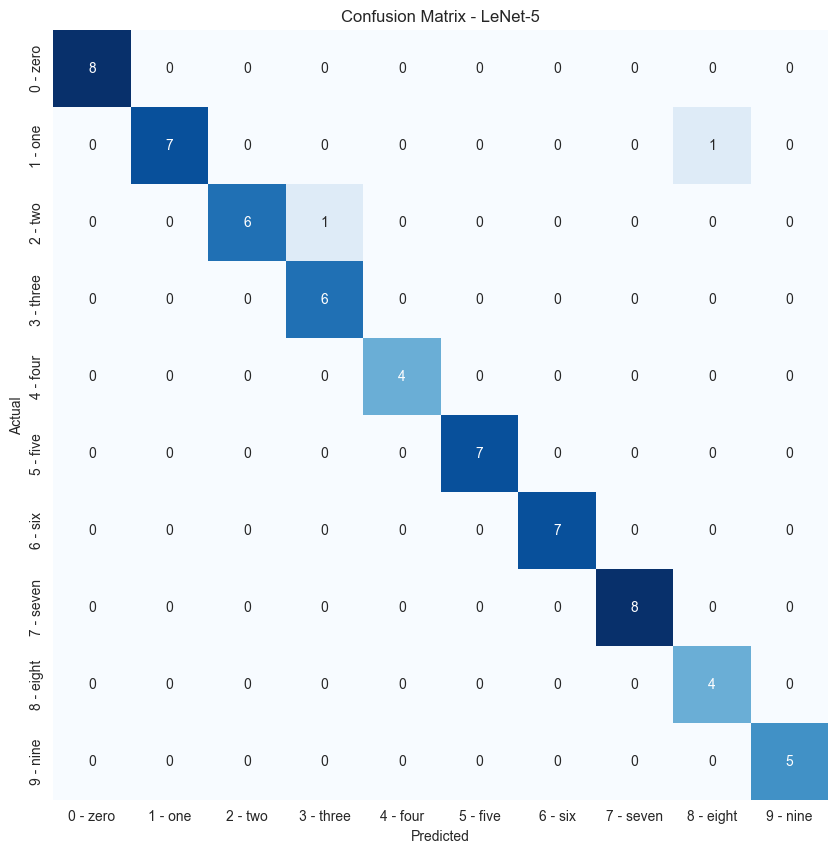

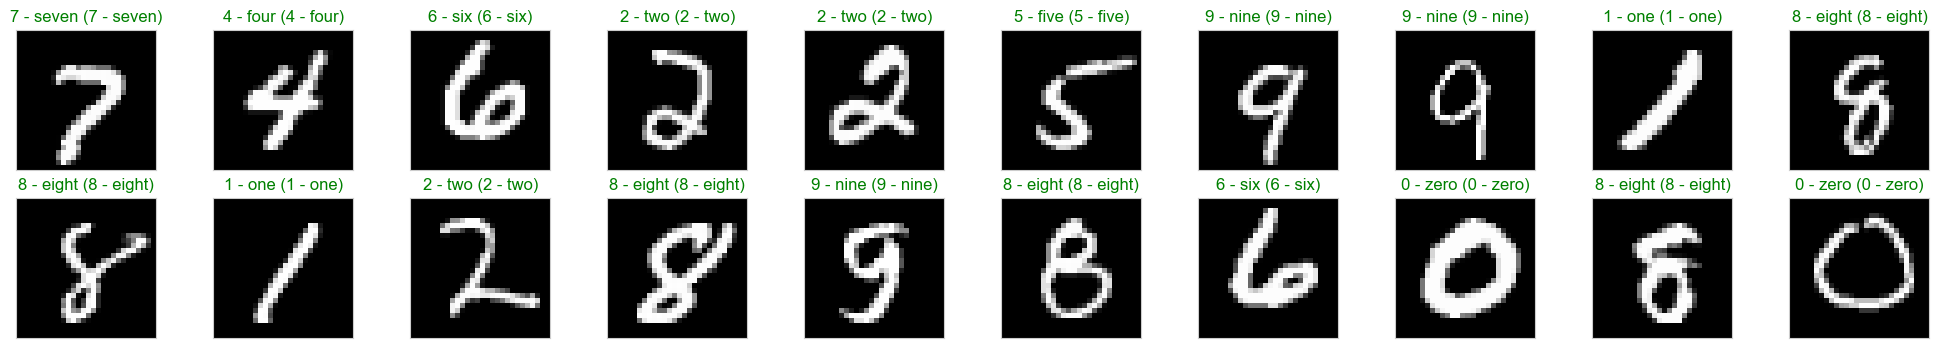

[[10  0  0  0  0  1  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  1  7]]


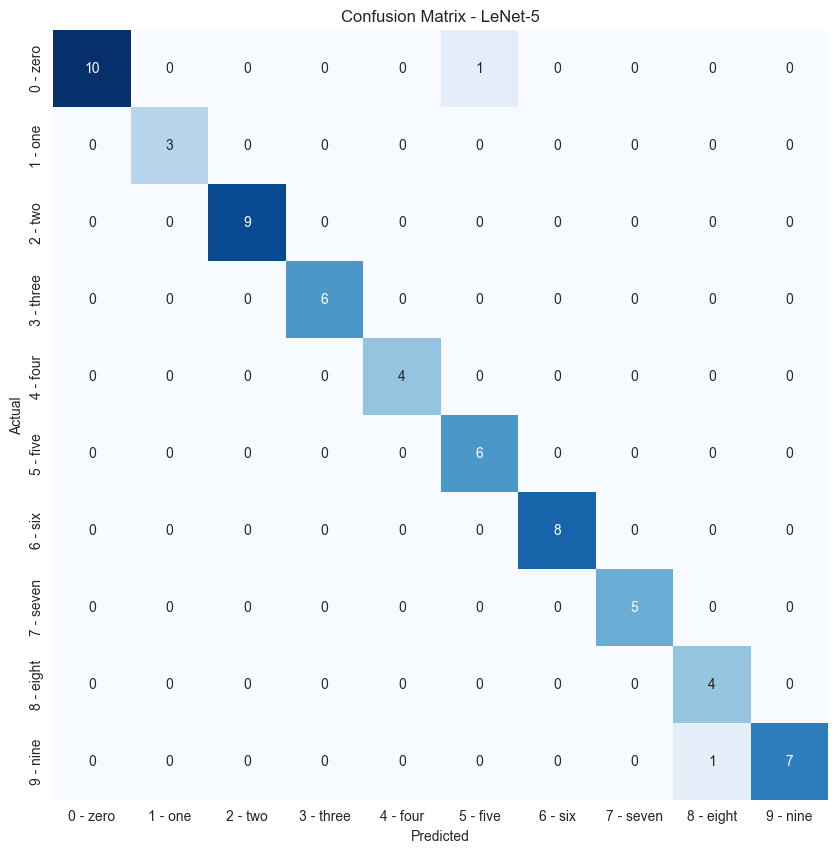

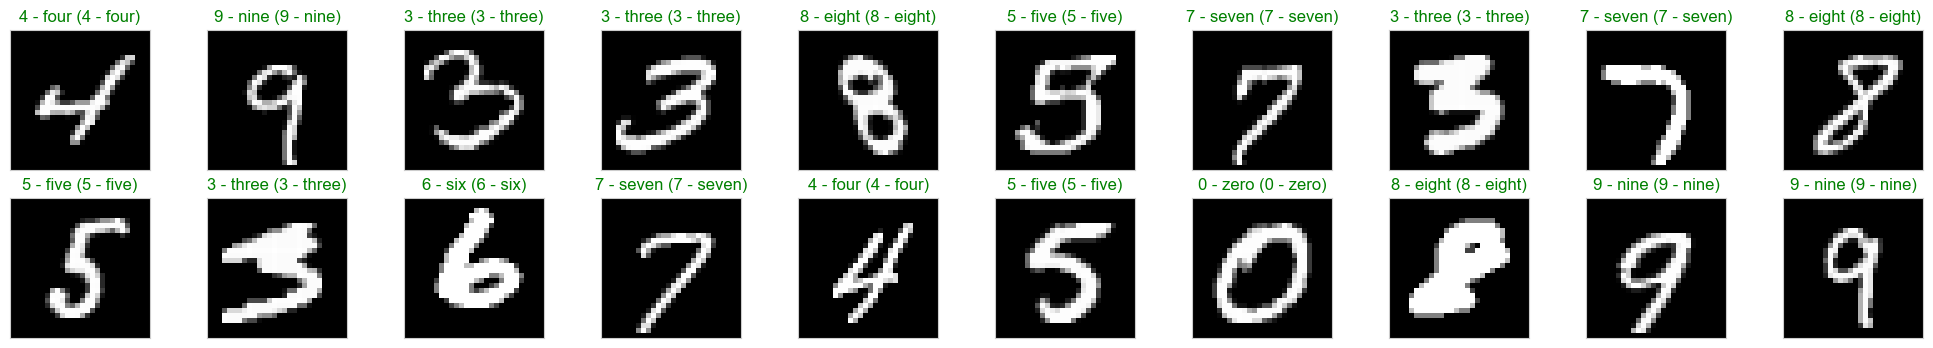

[[7 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0]
 [0 0 8 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 8 0 0 0 0 0]
 [0 0 0 0 0 9 0 0 0 0]
 [0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 1 0 0 4 0]
 [0 0 0 0 0 1 0 0 0 7]]


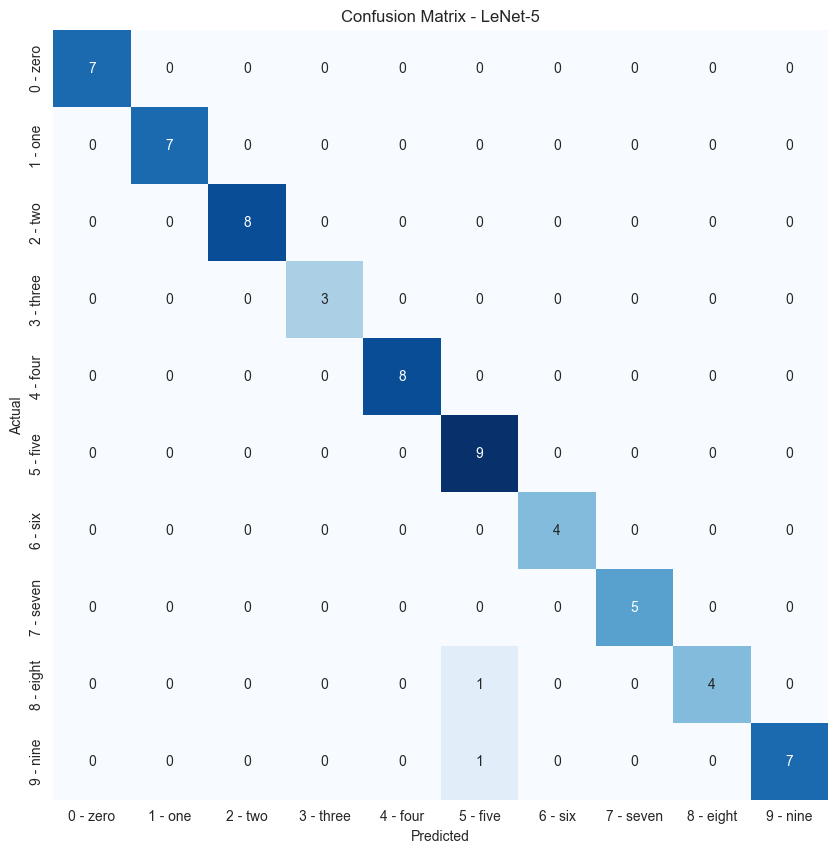

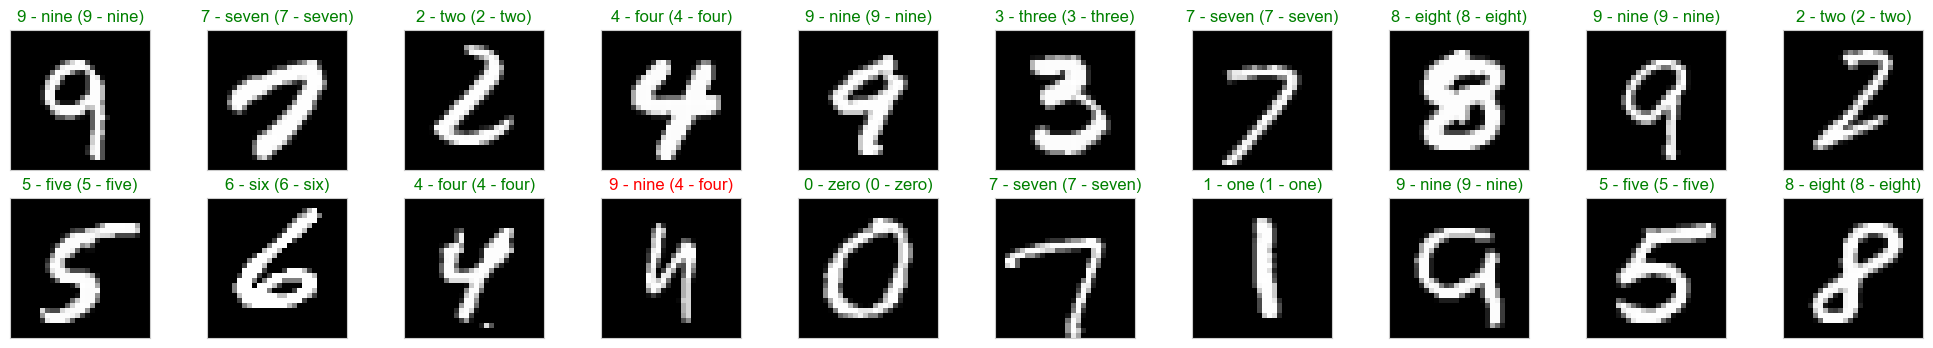

[[8 0 0 0 0 0 0 0 0 0]
 [0 8 0 0 0 0 0 0 0 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 9 0 0 0 0 0 0]
 [0 0 0 0 8 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 9 0 0]
 [0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 6]]


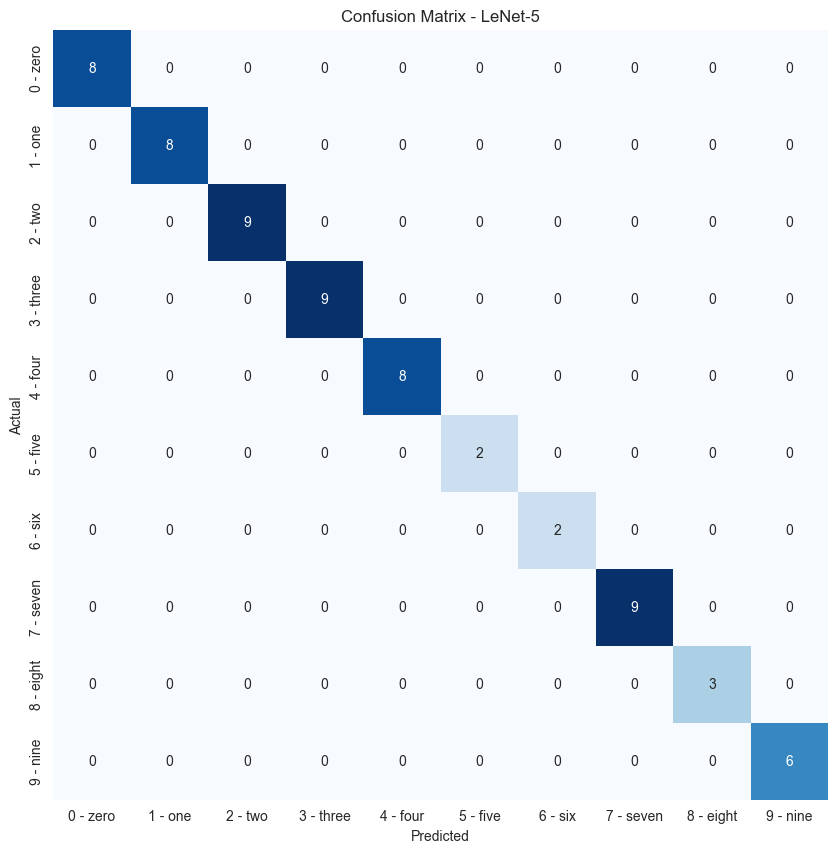

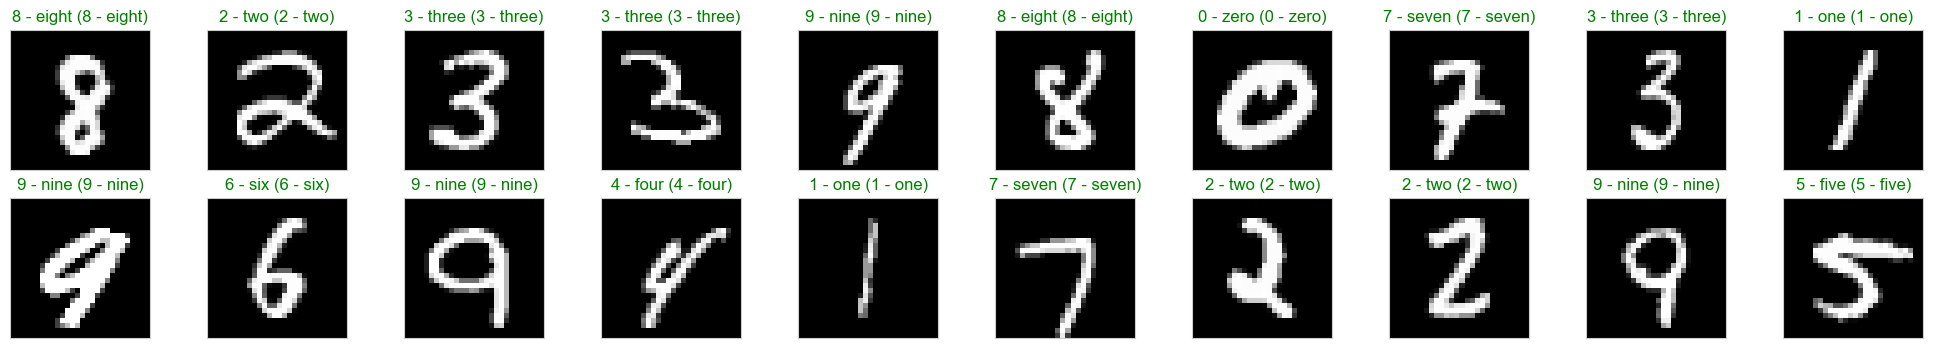

[[ 3  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0 11  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0 12  0  0]
 [ 0  0  0  1  0  0  0  0  7  1]
 [ 0  0  0  1  0  0  0  0  0  3]]


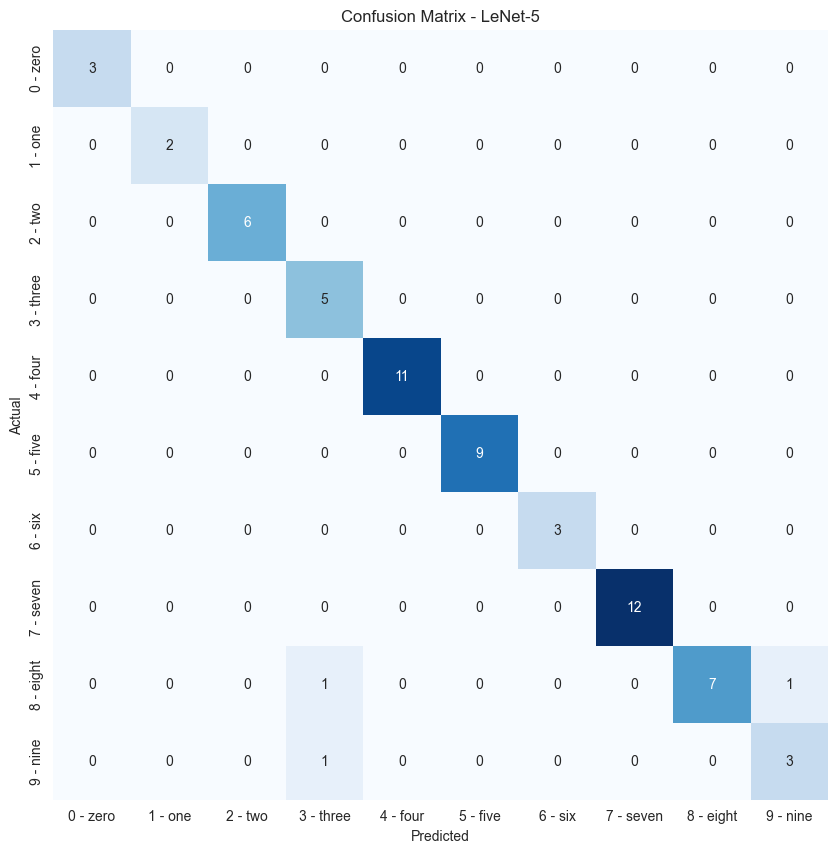

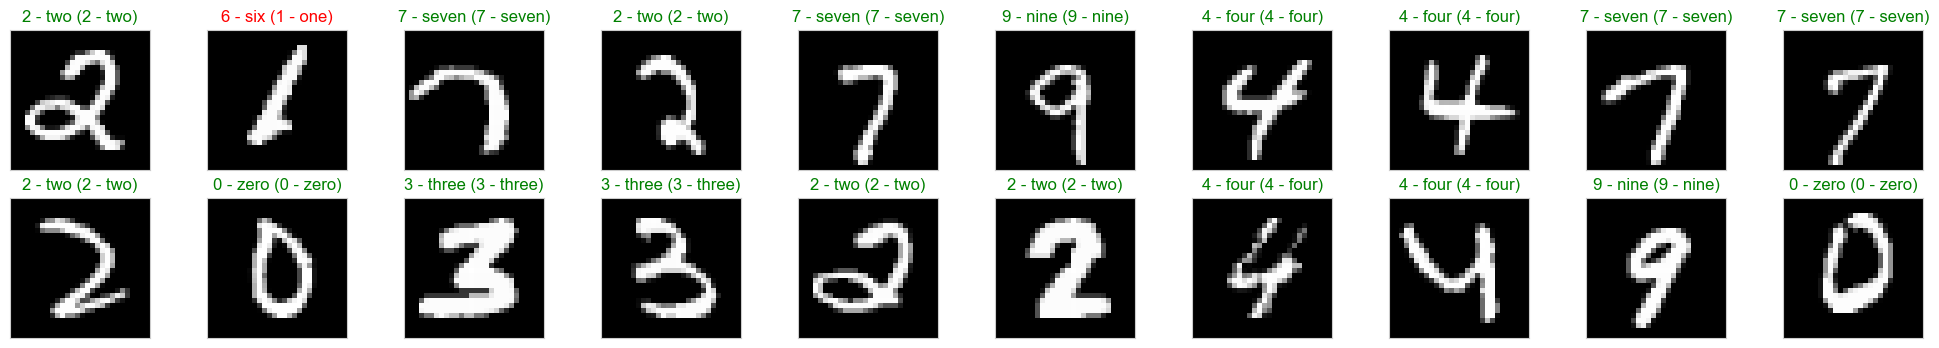

[[4 0 0 0 0 0 0 0 0 0]
 [0 6 0 0 0 0 0 0 1 0]
 [0 0 9 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 9 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 6 0]
 [0 0 0 0 0 1 0 0 0 8]]


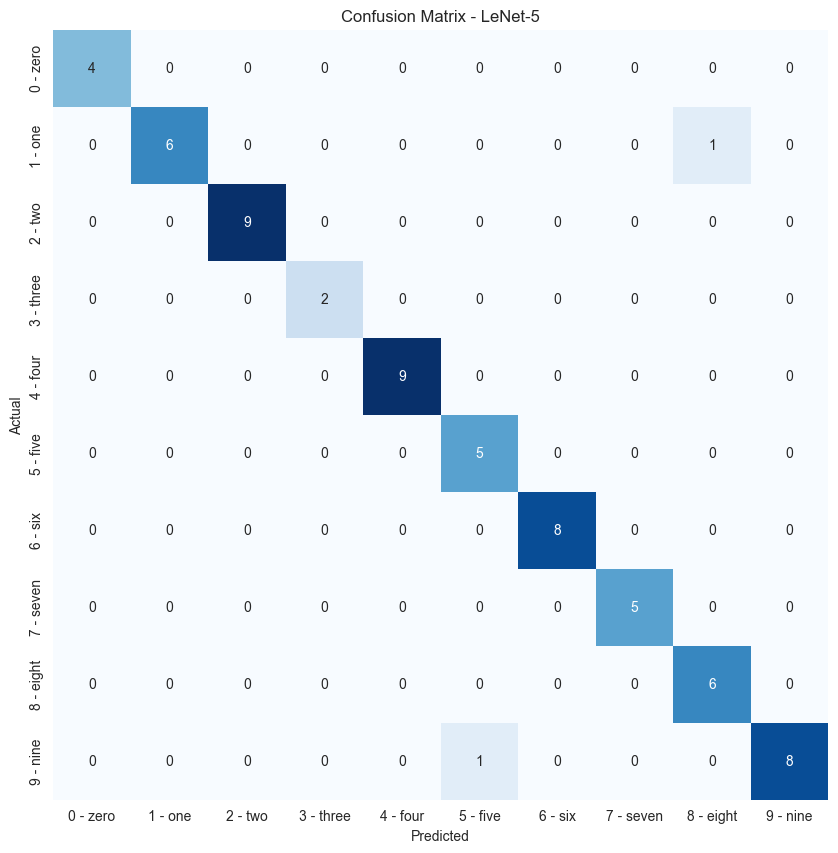

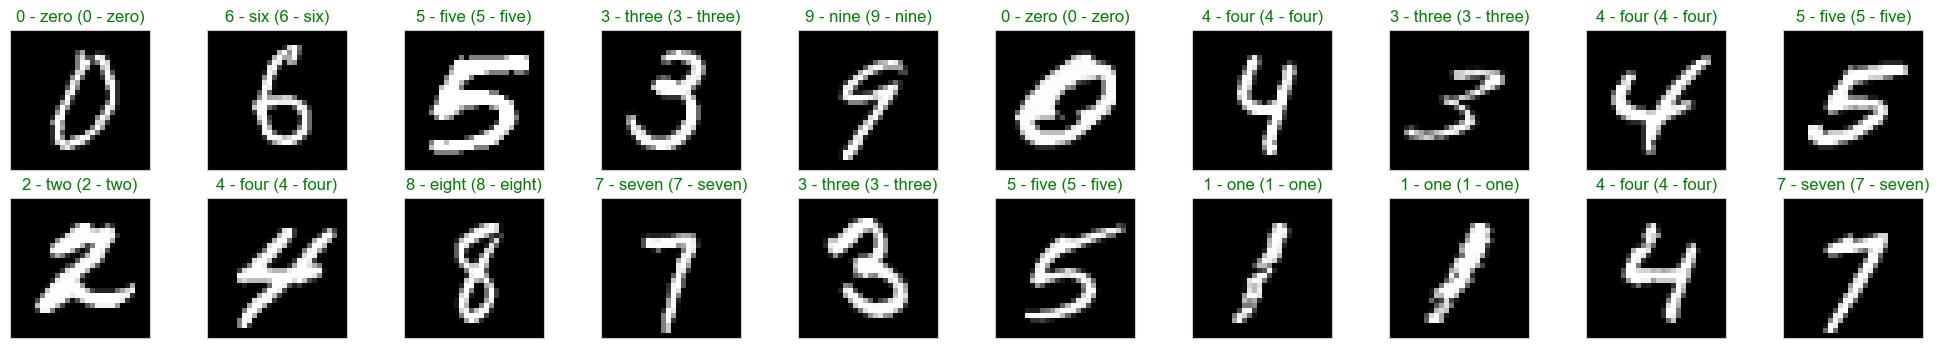

[[ 5  0  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  1  0]
 [ 0  0  7  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0  0]
 [ 0  0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  0  7]]


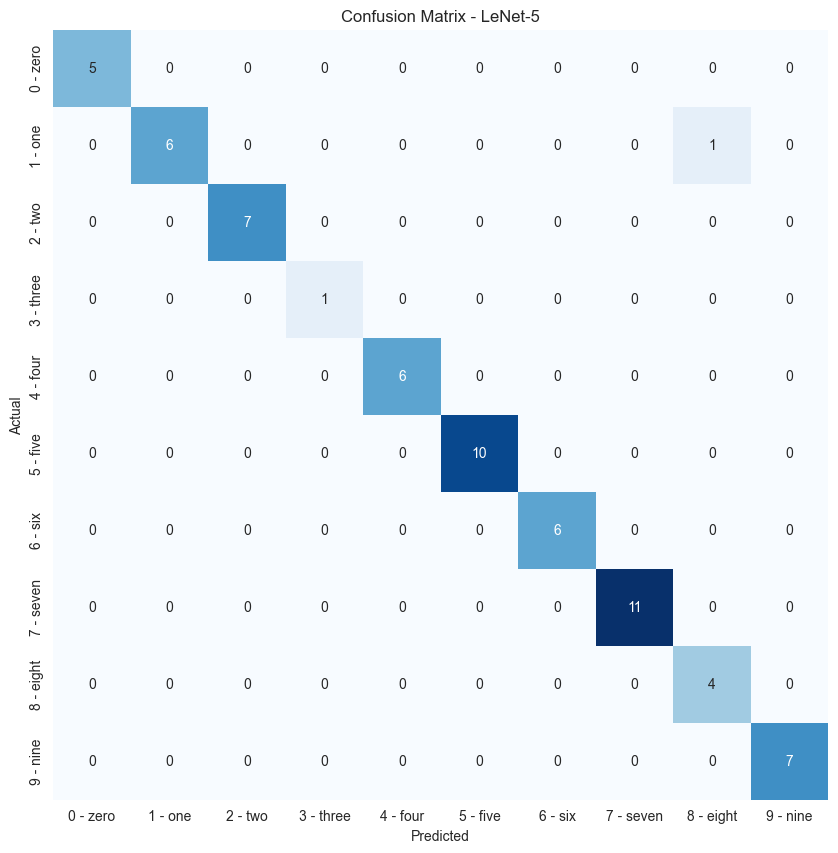

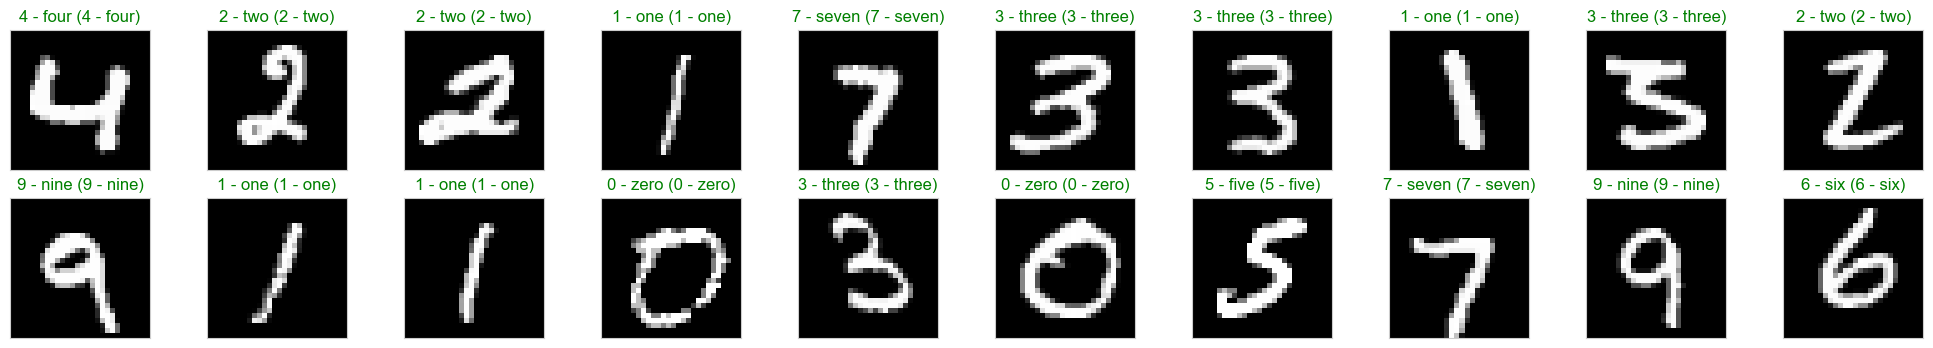

[[ 8  0  0  0  0  0  0  0  0  0]
 [ 0  7  0  1  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  1]
 [ 0  0  0  0  6  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  6  0  0]
 [ 0  0  1  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  0  0  4]]


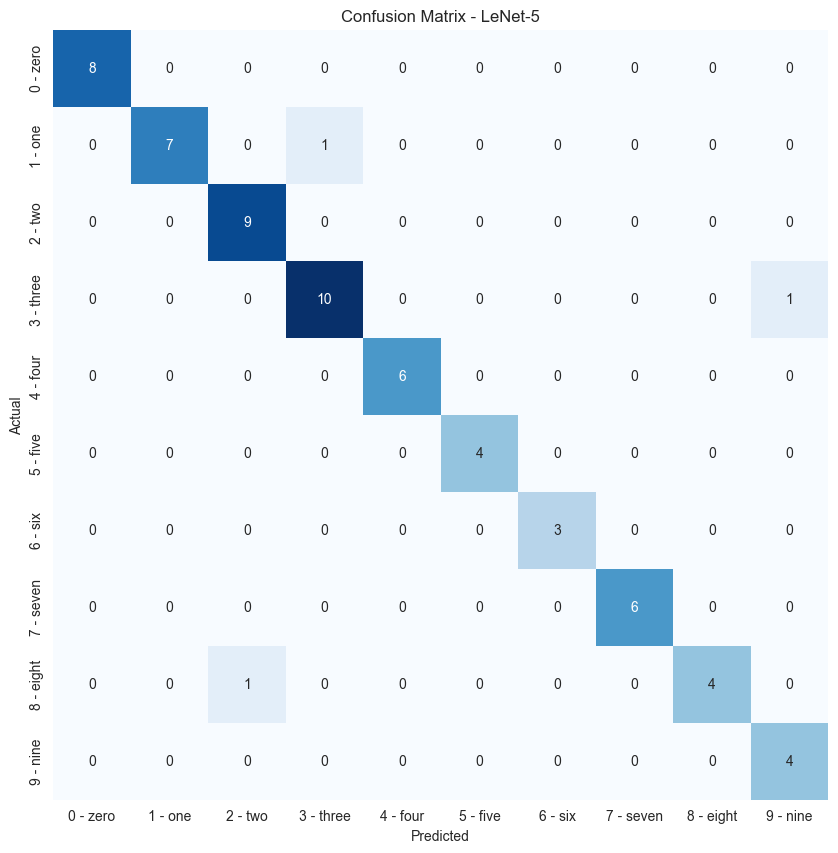

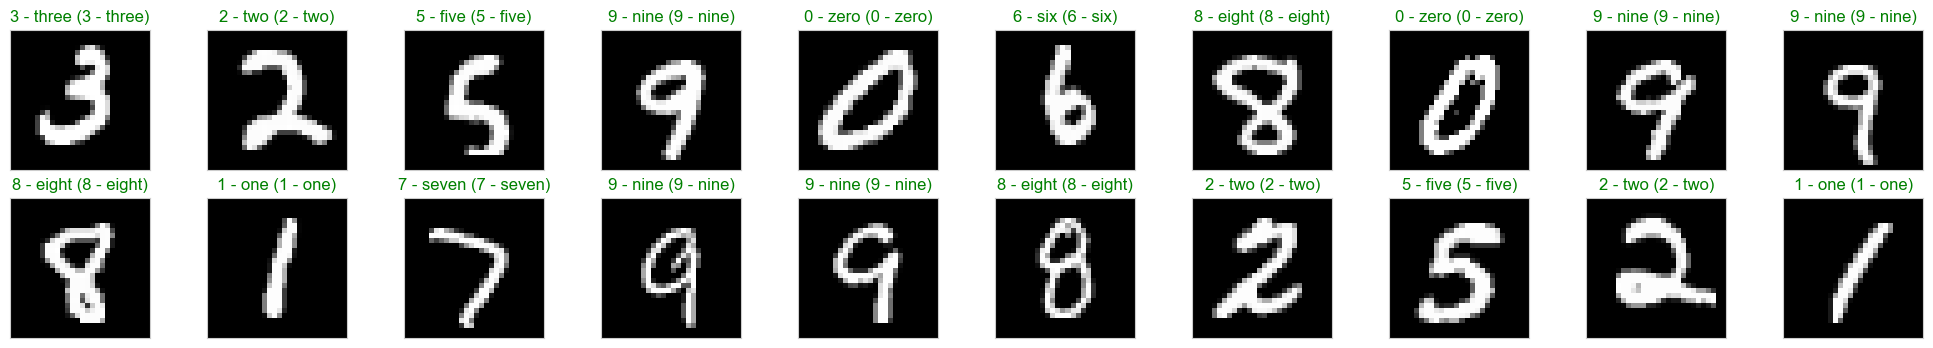

[[3 0 0 0 0 0 0 0 0 0]
 [0 7 0 0 0 0 1 0 0 0]
 [1 0 8 0 0 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 6 0 0 0 0 0]
 [0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 9 0 0 0]
 [0 0 0 0 0 0 0 8 0 0]
 [0 0 0 0 0 0 0 0 8 0]
 [0 0 0 0 0 0 0 0 0 6]]


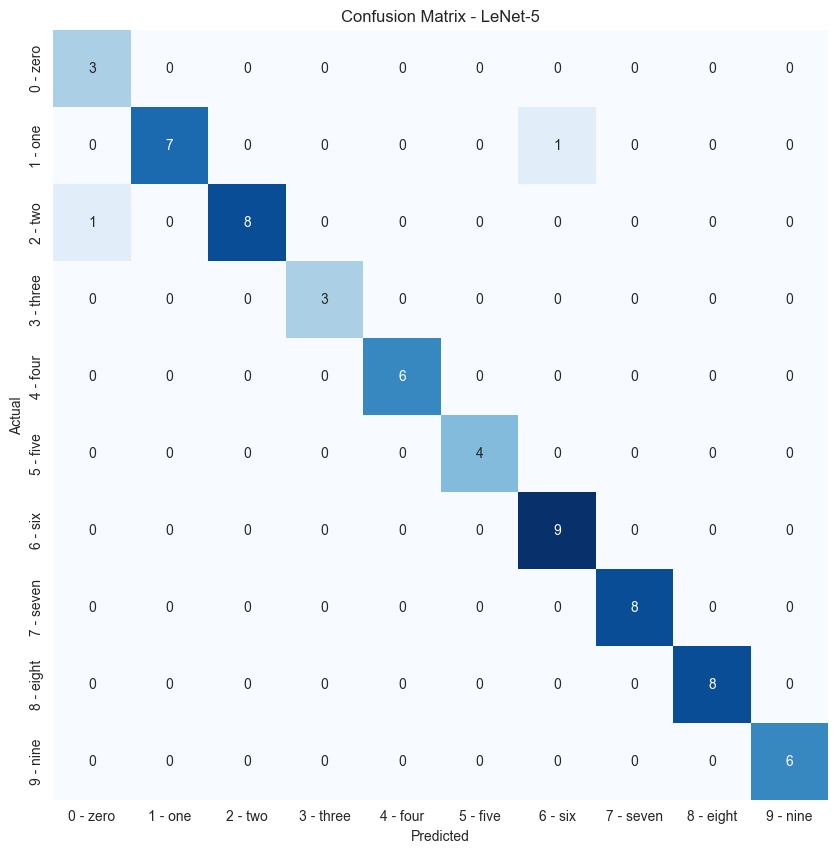

In [12]:
for i in range(10):
    # Visualize predictions by plot images and labels prediction
    # get a batch of test data
    data, targets = next(iter(test_dataloader))
    data = data.to(device=device)
    targets = targets.to(device=device)

    # get predictions
    with torch.inference_mode():
        targets_pred = model_lenet5(data)

        # get predicted class
        _, predictions = torch.max(targets_pred, dim=1)

        # plot the images in the batch, along with predicted and true labels
        fig = plt.figure(figsize=(25, 4))
        for idx in np.arange(20):
            ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
            ax.imshow(data[idx].cpu().squeeze(), cmap="gray")
            ax.set_title(f"{class_names[predictions[idx]]} ({class_names[targets[idx]]})", color=("green" if predictions[idx]==targets[idx] else "red"))
    plt.show()
    
    # Visualize predictions by plot confusion matrix
    # test using all test dataset
    data, targets = next(iter(test_dataloader))
    data = data.to(device=device)
    targets = targets.to(device=device)

    # get predictions
    with torch.inference_mode():
        targets_pred = model_lenet5(data)

        # get predicted class
        _, predictions = torch.max(targets_pred, dim=1)

        # confusion matrix
        cm = confusion_matrix(targets.cpu().numpy(), predictions.cpu().numpy())
        print(cm)

        # plot confusion matrix
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix - LeNet-5")

    plt.show()